In [1]:
from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import fastsca
import logging
import _rpstruct as rp
import _pnmf
from sklearn.decomposition import NMF
from sklearn import preprocessing
import random
from scipy.special import softmax
from sklearn.metrics.cluster import contingency_matrix,silhouette_score,adjusted_rand_score,calinski_harabasz_score,davies_bouldin_score
np.random.seed(42)

experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sca = fastsca.FASTSCA()
sca.config = args
sca.initdata()
# sca.loaddata()
# print(sca.data.mtx.shape)
fn = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id



In [85]:
df_y = pd.read_csv(fn+'_rp_bulk.csv.gz')
df_y.shape


(1146, 19798)

In [58]:
import numpy as np
import pandas as pd
from numpy.random import normal
np.random.seed(37)

df_w = pd.DataFrame([
[0.8,0.15,0.05],
[0.75,0.15,0.1],
[0.8,0.15,0.05],
[0.75,0.15,0.1],
[0.15,0.05,0.8],
[0.15,0.05,0.8],
[0.15,0.05,0.8],
[0.15,0.05,0.8],
[0.05,0.8,0.15],
[0.05,0.8,0.15],
[0.05,0.8,0.15],
[0.05,0.8,0.15],
])

print('W m x k',df_w.shape)

a = list(normal(5,1,100)) + list(normal(1,1,100)) + list(normal(1,1,100))
b = list(normal(1,1,100)) + list(normal(1,1,100)) + list(normal(5,1,100))
c = list(normal(1,1,100)) + list(normal(5,1,100)) + list(normal(1,1,100))
df_h = pd.DataFrame([a,b,c])

print('H k x n',df_h.shape)


df_y = pd.DataFrame(np.dot(df_w.to_numpy(),df_h.to_numpy())).T
print('A m x n',df_y.shape)


W m x k (12, 3)
H k x n (3, 300)
A m x n (300, 12)


In [88]:
import _pnmf,_dcpnmf
import importlib
importlib.reload(_dcpnmf)
importlib.reload(_pnmf)

# m = _pnmf.PoissonMF(n_components=3,verbose=True)
# res = m.fit(np.exp(df_y.to_numpy()))
m = _dcpnmf.DCPoissonMF(n_components=10)
res = m.fit(df_y.to_numpy())

updaing null model....


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_dcpnmf.py:76: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


	After ITERATION: 0	Objective: 3554065622.25	Old objective: -inf	Improvement: nan
3143345.6744376537
	After ITERATION: 1	Objective: 3554065622.25	Old objective: 3554065622.25	Improvement: 0.00000
3143345.67444157


(1146, 10) (1146, 10) (1146, 10) (1146, 10)
(10, 19798) (10, 19798) (10, 19798) (10, 19798)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_dcpnmf.py:172: RuntimeWarning: invalid value encountered in double_scalars
  self._update_theta(X)


	After ITERATION: 0	Objective: -22984623.03	Old objective: -inf	Improvement: nan
	After ITERATION: 1	Objective: -22456221.91	Old objective: -22984623.03	Improvement: 0.02299
	After ITERATION: 2	Objective: -21180938.68	Old objective: -22456221.91	Improvement: 0.05679
	After ITERATION: 3	Objective: -18076375.87	Old objective: -21180938.68	Improvement: 0.14657
	After ITERATION: 4	Objective: -12295922.83	Old objective: -18076375.87	Improvement: 0.31978
	After ITERATION: 5	Objective: -4707308.71	Old objective: -12295922.83	Improvement: 0.61717
	After ITERATION: 6	Objective: 3635912.45	Old objective: -4707308.71	Improvement: 1.77240
	After ITERATION: 7	Objective: 13417237.80	Old objective: 3635912.45	Improvement: 2.69020
	After ITERATION: 8	Objective: 26807918.25	Old objective: 13417237.80	Improvement: 0.99802
	After ITERATION: 9	Objective: 45511588.55	Old objective: 26807918.25	Improvement: 0.69769
	After ITERATION: 10	Objective: 69467924.48	Old objective: 45511588.55	Improvement: 0.52638
	

(10, 19798)


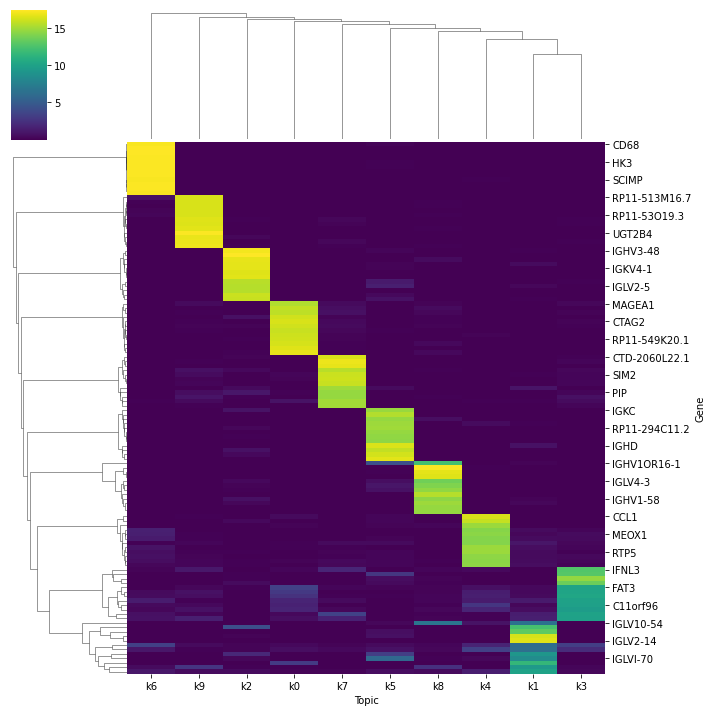

In [89]:
import _topics_util
import seaborn as sns

df_w = pd.DataFrame(res.Ebeta)
print(df_w.shape)
df_w.columns = sca.data.cols
df_top = _topics_util.get_topic_top_genes(df_w,top_n=12)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>10]=10
sns.clustermap(df_top.T,cmap='viridis')

<AxesSubplot:>

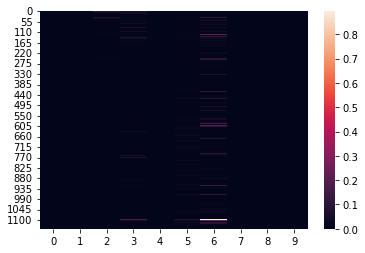

In [28]:
sns.heatmap(res.Etheta)

In [15]:
# ed * np.sum(ef)
ef

array([[0.96087166, 0.96336832, 0.96087166, 0.96336832, 0.99885928,
        0.99885928, 0.99885928, 0.99885928, 0.96236968, 0.96236968,
        0.96236968, 0.96236968]])

In [19]:
np.dot(np.exp(elogt), np.exp(elogb)).shape

(300, 12)

In [18]:
elogt = res.Elogtheta
elogb = res.Elogbeta

In [15]:
t = elogt + elogb
t.shape

ValueError: operands could not be broadcast together with shapes (300,3) (3,12) 

<AxesSubplot:>

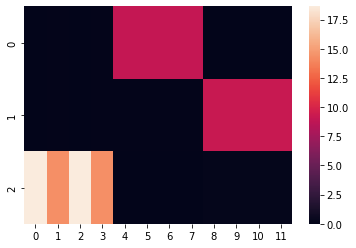

In [117]:
from sklearn.decomposition import NMF
model = NMF(n_components=3, init='random', random_state=0)
H = model.fit_transform(np.exp(df_y.to_numpy()))
W = model.components_
sns.heatmap(W)